In [2]:
import pickle as pkl
import os
from datetime import datetime, date, timedelta
import json
from collections import defaultdict
import geopandas as gpd
import numpy as np
import pystac_client
import planetary_computer
import rioxarray
import xarray as xr
import rasterio
from rasterio.enums import Resampling
from rioxarray.exceptions import NoDataInBounds
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

county_boundary = gpd.read_file("../data/county_boundary.shp")
tiles_data_dir = "../data/tiles_gdb"
tiles_geojson_path = "../data/tiles.geojson"
tiles_gdf = gpd.read_file(tiles_geojson_path)

with open('../data/failed_downloads.pkl', 'rb') as f:
    failed_downloads = pkl.load(f)

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)
query = {"eo:cloud_cover": {"lt": 1}}

collections=["sentinel-2-l2a"]

# Dates to query
start = "2016-01-01"
end = "2024-08-31"

bands = ["B02", "B03", "B04", "B08"]
bands_map = {"B02": "blue", "B03": "green", "B04": "red", "B08": "nir"}
gsd = 10
epsg = 32617

def select_dates_best_spread(dates_list, num_per_year=4):
    # Sort the dates list
    dates_list.sort()
    
    # Determine target months based on the desired number per year
    target_months = {
        4: [3, 6, 9, 12],  # Default quarters: March, June, September, December
        3: [4, 8, 12],     # For 3 dates per year: April, August, December
        2: [6, 12],        # For 2 dates per year: June, December
        1: [6]             # For 1 date per year: June
    }.get(num_per_year, [6])  # Default to June if an unexpected `num_per_year` is given
    
    # Group dates by year
    dates_by_year = defaultdict(list)
    for d in dates_list:
        dates_by_year[d.year].append(d)
    
    selected_dates = []
    
    # Iterate over each year and select the best spread dates
    for year in sorted(dates_by_year.keys()):
        available_dates = dates_by_year[year]
        
        for month in target_months:
            # Set the target date as the 1st of the target month
            target_date_in_year = date(year, month, 1)
            
            # Find the closest date in the available dates to the target date
            closest_date = min(available_dates, key=lambda d: abs(d - target_date_in_year))
            
            # Check if the selected date is not already in the list
            if closest_date not in selected_dates:
                selected_dates.append(closest_date)
    
    # Post-process to ensure cross-year spread is handled
    selected_dates.sort()
    return selected_dates

with open("../data/available_dates.pkl", "rb") as f:
    available_dates = pkl.load(f)
selected_dates = select_dates_best_spread([d for d in available_dates if d !=  date(2017, 5, 16) 
                                           and d != date(2024, 8, 27)], 3) # 5/16 is basically unavailable, and 8/25 is already there

Skipping field data_files: unsupported OGR type: 5


In [3]:
# Function to query STAC items for a tile
def query_stac_tile(tile_geometry, catalog, start, end, 
                    query, collections=["sentinel-2-l2a"], 
                    limit=1000):
    # Get the bounds of the tile in WGS84
    tile_wgs84 = gpd.GeoSeries([tile_geometry], crs="EPSG:32617").to_crs("EPSG:4326").iloc[0]
    minx, miny, maxx, maxy = tile_wgs84.bounds
    bbox = [minx, miny, maxx, maxy]

    # Perform the search
    search = catalog.search(
        collections=collections,
        bbox=bbox,
        datetime=f"{start}/{end}",
        limit=limit,
        query=query
    )
    # Get the items from the search results
    items = list(search.item_collection())
    return items

def get_subregion(dataset, bounds):
    min_x, min_y, max_x, max_y = bounds
    # Subset the dataset using xarray's sel function
    subregion = dataset.sel(
        x=slice(min_x, max_x),  # X-coordinate bounds
        y=slice(max_y, min_y)   # Y-coordinate bounds (flip due to coordinate system)
    )
    return subregion

# Function to get images from item
def get_images_from_item(item, bands, output_file_path, 
                         chunk_size=2048, dtype=np.float32, 
                         crs="EPSG:32617", bounds=None):
    # Check if the file already exists
    if not os.path.exists(output_file_path):

        band_datasets = []
        # Loop through bands and collect data
        for band in bands:
            # Sign the asset URLs
            asset_href = planetary_computer.sign(item.assets[band].href)
            # Open the image using rioxarray
            with rasterio.Env():
                ds = rioxarray.open_rasterio(
                    asset_href,
                    chunks={"band": -1, "x": chunk_size, "y": chunk_size},
                    lock=False
                ).astype(dtype)
                if ds.rio.crs != crs:
                    ds = ds.rio.reproject(
                        crs, 
                        resampling=Resampling.nearest,
                        num_threads=2
                    )
                if bounds is not None:
                    ds = get_subregion(ds, bounds)
                band_datasets.append(ds)

        # Stack bands into a single dataset
        stacked_ds = xr.concat(band_datasets, dim='band')

        # Store time as an attribute
        naive_datetime = item.datetime.replace(tzinfo=None)
        time_value = np.datetime64(naive_datetime, 'ns')
        stacked_ds.attrs['time'] = str(time_value)
        
        # Save the stacked dataset to a single GeoTIFF file
        # stacked_ds.rio.to_raster(output_file_path)
        # Write the data using Dask and rioxarray, with windowed=True and tiled=True
        with rasterio.Env(GDAL_CACHEMAX=512):  # Set cache size to 512 MB
            stacked_ds.rio.to_raster(
                output_file_path,
                tiled=True,
                windowed=True,
                blockxsize=256,
                blockysize=256,
                compress="deflate",
                num_threads=2,
                bigtiff='yes'
            )
    return output_file_path

# Function to clean up bounds for filename
def clean_bounds(bounds):
    minx, miny, maxx, maxy = bounds
    # Round to 3 decimal places and remove any special characters
    minx_str = f"{minx:.3f}".replace('.', '_')
    miny_str = f"{miny:.3f}".replace('.', '_')
    maxx_str = f"{maxx:.3f}".replace('.', '_')
    maxy_str = f"{maxy:.3f}".replace('.', '_')
    # Combine into a single string
    bounds_str = f"{minx_str}_{miny_str}_{maxx_str}_{maxy_str}"
    return bounds_str

In [7]:
def requery_failed_downloads(failed_downloads, catalog, query, 
                          collections=["sentinel-2-l2a"], limit=1000, 
                          save_dir="../data/tiles_gdb", buffer_days=60):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    no_data_in_bounds = []
    for failed_download in failed_downloads:
        idx = failed_download['idx'] 
        tile_polygon = failed_download['tile_geometry']  
        query_date = failed_download['query_date']
        buffer_days = 0  # Start without buffer
        print(f"Re-querying tile for date: {query_date} at coordinates: {failed_download['tile_bounds']}")
        
        while buffer_days <= buffer_days: 
            start_date = query_date - timedelta(days=buffer_days)
            end_date = query_date + timedelta(days=buffer_days)
            
            # Query the STAC catalog for the missing tile
            items = query_stac_tile(tile_polygon, catalog, start_date.isoformat(), end_date.isoformat(), 
                                    query, collections=collections, limit=limit)
            
            if items:
                for item in items:
                    saved = False
                    # Define the output file path before querying
                    tile_bounds = tile_polygon.bounds
                    bounds_str = clean_bounds(tile_bounds)
                    band_sfx = "_".join(bands)
                    output_file = os.path.join(tiles_data_dir, f"tile_{idx}_{bounds_str}_{query_date.isoformat()}_{band_sfx}.tif")
                    try:
                        if not os.path.exists(output_file):
                            # Save the queried image
                            get_images_from_item(item, bands, output_file, bounds=tile_polygon.bounds)
                            print(f"Saved re-queried tile to {output_file}")
                        saved = True
                    except NoDataInBounds as e:
                        print(e)
                if not saved:
                    no_data_in_bounds.append({
                            'idx': idx,
                            'tile_polygon': tile_polygon,
                            'query_date': query_date 
                        })
                    print(f"Appended {tile_polygon.bounds} {query_date} to `no_data_in_bounds`.")
                
                break  # Stop if data is found and saved
            
            buffer_days += 2  # Increase the buffer by 2 days if no data found

        if buffer_days > buffer_days:
            print(f"Failed to retrieve data for tile {failed_download['tile_bounds']} on date {query_date} within buffer range.")
    return no_data_in_bounds
            

tile_geometry = tiles_gdf.at[17, "geometry"]

no_data_in_bounds = requery_failed_downloads([{
    "idx": 17,
    "query_date": date(2018, 11, 27),
    "tile_geometry": tile_geometry,
    "tile_bounds": tile_geometry.bounds,
    "bounds_str": clean_bounds(tile_geometry.bounds),
    "band_sfx": "_".join(bands),
    "bands":bands
}], catalog, query=query, save_dir="../data/failed_downloads")

Re-querying tile for date: 2018-11-27 at coordinates: (709800.0, 3930600.0, 710400.0, 3931200.0)
Unable to determine bounds from coordinates.
Appended (709800.0, 3930600.0, 710400.0, 3931200.0) 2018-11-27 to `no_data_in_bounds`.


In [ ]:
# TODO: Maybe omit 11/27?? Or is it just tile 17?

In [ ]:

def parse_date_from_filename(filename):
    """
    Parse the date from the file name.
    The date is assumed to be in ISO format (YYYY-MM-DD) within the file name.
    The date is typically the part just before the band names, which we assume is the third-to-last part.
    """
    try:
        # Normalize the file path to handle potential backward slashes and extract the filename
        base_name = os.path.basename(filename)
        # Split by underscore and extract the date part (which is third-to-last based on the example)
        parts = base_name.split('_')
        # The date part is the one right before the bands (3rd from last)
        date_str = parts[-5]
        # Convert the date string to a date object
        return datetime.strptime(date_str, '%Y-%m-%d').date()
    except (ValueError, IndexError) as e:
        # In case of any error in parsing, return None and print error for debugging
        print(f"Error parsing date from filename '{filename}': {e}")
        return None

def assign_files_to_dates(tiles_gdf, max_buffer_days, selected_dates, tiles_data_dir='../data/tiles_gdb'):

    # Initialize a new column in tiles_gdf to hold the date-to-files mapping
    if 'date_files_mapping' not in tiles_gdf.columns:
        tiles_gdf['date_files_mapping'] = [{} for _ in range(len(tiles_gdf))]

    # Convert selected_dates to strings for GeoJSON compatibility
    selected_dates_str = [d.strftime('%Y-%m-%d') for d in selected_dates]

    for idx, tile in tiles_gdf.iterrows():
        # Get the list of files associated with the current tile
        tile_bounds = tile['geometry'].bounds
        bounds_str = clean_bounds(tile_bounds)
        band_sfx = "_".join(bands)
        data_files = [os.path.join(tiles_data_dir, f"tile_{idx}_{bounds_str}_{query_date.isoformat()}_{band_sfx}.tif") \
                      for query_date in selected_dates]
        
        # Initialize a dictionary with each selected date (as string) as a key and an empty list as the value
        date_files = {selected_date: [] for selected_date in selected_dates_str}
        
        for file in data_files:
            # Extract the date from the file name
            file_date = parse_date_from_filename(file)
            if not file_date:
                continue  # Skip files without valid dates

            # Convert file_date to string for comparison
            file_date_str = file_date.strftime('%Y-%m-%d')
            
            # Check if the file date is within the buffer for any of the selected dates
            for target_date in selected_dates:
                if abs((file_date - target_date).days) <= max_buffer_days:
                    # Add the file to the list of files for the matching target date
                    date_files[target_date.strftime('%Y-%m-%d')].append(file)
        
        # Update the 'date_files_mapping' column with the date-to-files dictionary
        tiles_gdf.at[idx, 'date_files_mapping'] = date_files
    
    # Drop the old 'data_files' column since it's now replaced by 'date_files_mapping'
    if 'data_files' in tiles_gdf.columns:
        tiles_gdf = tiles_gdf.drop(columns=['data_files'])
    
    return tiles_gdf

# Call the function to update the GeoDataFrame
updated_tiles_gdf = assign_files_to_dates(tiles_gdf, max_buffer_days=60, selected_dates=selected_dates, tiles_data_dir='../data/tiles_gdb')

# Save the updated GeoDataFrame to GeoJSON
updated_tiles_geojson_path = "../data/tiles_with_dates.geojson"
updated_tiles_gdf.to_file(updated_tiles_geojson_path, driver='GeoJSON')

with open(updated_tiles_geojson_path, 'r') as file:
    geojson_data = json.load(file)

In [11]:



# Initialize containers for results
empty_date_records = []
multiple_file_records = []
non_empty_counts = defaultdict(int)

# Iterate over the features
for feature in geojson_data['features']:
    date_files_mapping = feature['properties']['date_files_mapping']
    
    # Check for empty lists and lists with more than one file
    for date, file_list in date_files_mapping.items():
        if len(file_list) == 0:
            empty_date_records.append((feature['geometry']['coordinates'], date))
        if len(file_list) > 1:
            multiple_file_records.append((feature['geometry']['coordinates'], date, file_list))
        
        # Count non-empty lists per date
        if len(file_list) > 0:
            non_empty_counts[date] += 1

print(f"Updated tiles GeoDataFrame saved to {updated_tiles_geojson_path}")

Updated tiles GeoDataFrame saved to ../data/tiles_with_dates.geojson


In [14]:
missing_tiles_coords

[]

C:\Users\btripp\AppData\Local\Temp\2\ipykernel_9528\540960019.py:15: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  missing_tiles_gdf.plot(ax=ax, color='black')


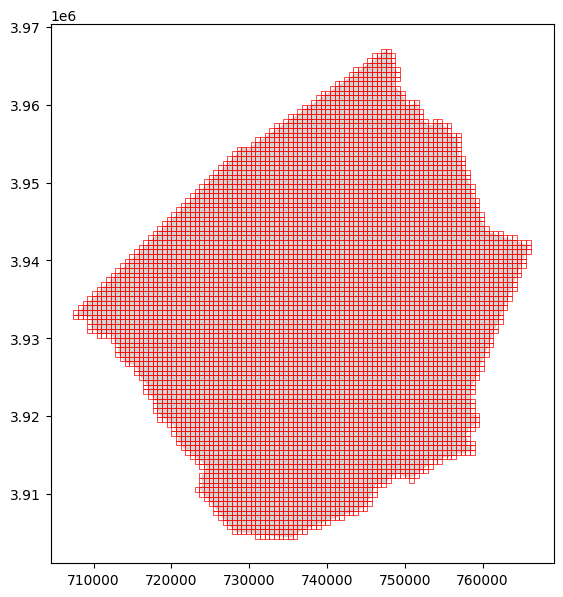

In [12]:
# Extract unique tile coordinates and flatten them to ensure they are tuples of floats
missing_tiles_coords = [tuple([tuple(coord) for coord in record[0]]) for record in empty_date_records]
missing_tiles_coords = [i[0] for i in missing_tiles_coords]

# Convert coordinates to polygons for plotting
missing_tiles_gdf = gpd.GeoDataFrame(
    geometry=[Polygon(coords) for coords in missing_tiles_coords],  # Ensure valid polygons
    crs=updated_tiles_gdf.crs
).drop_duplicates()

# Visualize the tiles, filling in each tile with ANY missing dates (using the unique coordinates from empty_date_records)
ax = county_boundary.plot(color='lightgray', figsize=(7, 7))
updated_tiles_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=0.5)
# Fill empty tiles with black
missing_tiles_gdf.plot(ax=ax, color='black')
plt.show()